In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Optymalizacja hiperparametrów

In [2]:
import optuna
from models import LSTMRegressorFeatures
from training_functions import train_lstm_features
from helper_functions import get_accuracy_features, plot_training, get_confusion_matrix_features, plot_confusion_matrix

In [3]:
def slicing(sequence: list):
    """Take a slice of the sequence."""
    try:
        start_idx = np.random.randint(0, len(sequence))
        end_idx = np.random.randint(start_idx, len(sequence))
        return sequence[start_idx:end_idx]
    except:
        return sequence

def random_erase(sequence: list, p=0.1):
    """Randomly erase some notes."""
    mask = np.random.choice([0, 1], size=len(sequence), p=[p, 1-p])
    return sequence * mask

def random_shift(sequence: list, max_shift=100):
    """Randomly shift the sequence."""
    shift = np.random.randint(-max_shift, max_shift)
    new_sequence = np.roll(sequence, shift)
    return new_sequence

In [4]:
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks

feature_names = ['mean', 'variance', 'standard_deviation', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast']

def add_features(seq):
    _data = np.array(seq)
    mean = np.mean(_data)
    variance = np.var(_data)
    standard_deviation = np.std(_data)
    fft_vals = fft(_data)
    fft_abs = np.abs(fft_vals)
    frequencies = np.linspace(0, len(_data), len(_data))
    spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)
    spectral_bandwidth = np.sum(fft_abs * ((frequencies - spectral_centroid) ** 2)) / np.sum(fft_abs)
    peaks, _ = find_peaks(fft_abs)
    valleys, _ = find_peaks(-fft_abs)
    spectral_contrast = np.mean(fft_abs[peaks]) - np.mean(fft_abs[valleys])
    return np.array([mean, variance, standard_deviation, spectral_centroid, spectral_bandwidth, spectral_contrast])

In [5]:
def feature_pipeline(data):
    from sklearn.preprocessing import MinMaxScaler

    feat_data = data.copy().reset_index(drop=True)
    feat_data['features'] = feat_data['sequence'].apply(add_features)
    for i, name in enumerate(feature_names):
        feat_data[name] = feat_data['features'].apply(lambda x: x[i])
    feat_data.drop(columns=['features'], inplace=True)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(feat_data[feature_names])
    y = feat_data['composer']

    ret = pd.DataFrame(X, columns=feature_names)
    ret['composer'] = y
    ret['sequence'] = feat_data['sequence']

    return ret

In [6]:
def augument_pipeline(data):
    funcs = [slicing, random_erase, random_shift]
    func_data = pd.DataFrame()
    for func in funcs:
        augmented_data = data.copy()
        augmented_data['sequence'] = augmented_data['sequence'].apply(lambda x: func(x))
        func_data = pd.concat([func_data, augmented_data])
    data = pd.concat([data, func_data])
    data.reset_index(drop=True, inplace=True)
    return data

In [7]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data.iloc[idx]['sequence'], dtype=torch.float32)
        feat_tensors = [torch.tensor(self.data.iloc[idx][name], dtype=torch.float32) for name in feature_names]
        features = torch.stack(feat_tensors)
        composer = torch.tensor(self.data.iloc[idx]['composer'], dtype=torch.float32)
        return seq, features, composer

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

data = pickle.load(open('train.pkl', 'rb'))
data = pd.DataFrame(data, columns=['sequence', 'composer'])
max_len = data['sequence'].apply(len).max()

X = pad_sequences(data['sequence'].tolist(), padding='post', maxlen=max_len)
y = np.array(data['composer'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

train = pd.DataFrame({'sequence': X_train.tolist(), 'composer': y_train})
val = pd.DataFrame({'sequence': X_val.tolist(), 'composer': y_val})
test = pd.DataFrame({'sequence': X_test.tolist(), 'composer': y_test})

train, val = train_test_split(data, test_size=0.4, random_state=42, stratify=data['composer'])
val, test = train_test_split(val, test_size=0.5)
train = augument_pipeline(train)
train = train[train['sequence'].apply(len) > 0]
train = feature_pipeline(train)
val = feature_pipeline(val)
test = feature_pipeline(test)
train = train[~train.isna().any(axis=1)]
val = val[~val.isna().any(axis=1)]
test = test[~test.isna().any(axis=1)]
train = train[train['sequence'].apply(len) > 0]

train['sequence'] = train['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
val['sequence'] = val['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
test['sequence'] = test['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
display(train)

2024-05-26 22:47:02.321182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 22:47:02.978123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_396643/956652262.py:15: RuntimeWarning: invalid value encountered in scalar divide
  spectral_centroid = np.sum(fft

,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast,composer,sequence
0,0.437619,0.306477,0.553604,0.045942,0.002476,0.189587,4,"[32.0, 146.0, 33.0, 125.0, 92.0, 125.0, 159.0,..."
1,0.393721,0.384757,0.620288,0.029882,0.001019,0.213198,0,"[-1.0, -1.0, -1.0, 64.0, 145.0, 38.0, 78.0, 13..."
2,0.381108,0.235443,0.485224,0.009431,0.000120,0.102663,0,"[64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64..."
3,0.315805,0.313572,0.559975,0.029942,0.001042,0.203740,0,"[0.0, 12.0, 12.0, 12.0, 124.0, 124.0, 15.0, 15..."
4,0.330028,0.315815,0.561974,0.083966,0.007946,0.231745,0,"[-1.0, -1.0, -1.0, -1.0, 88.0, 88.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
6985,0.386772,0.350022,0.591626,0.027408,0.000773,0.151428,0,"[69.0, 88.0, 119.0, 0.0, 112.0, 0.0, 0.0, 112...."
6986,0.309861,0.308498,0.555426,0.016595,0.000355,0.131421,0,"[3.0, 3.0, 145.0, 47.0, 77.0, 12.0, 92.0, 47.0..."
6987,0.314828,0.349090,0.590838,0.030163,0.001024,0.209803,0,"[28.0, 28.0, 28.0, 78.0, 159.0, 92.0, 13.0, 79..."
6988,0.313231,0.298697,0.546532,0.054465,0.003216,0.186551,0,"[13.0, 28.0, 12.0, 28.0, 28.0, 12.0, 13.0, 12...."


In [9]:
from helper_functions import pad_collate_feat

train_dataset = FeatureDataset(train)
val_dataset = FeatureDataset(val)
test_dataset = FeatureDataset(test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate_feat)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)

In [10]:
def objective(trial):
    hidden_sizes = [16, 32, 64]
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    hidden_size = trial.suggest_categorical('hidden_size', hidden_sizes)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
    model = model.to(device)
    class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
    class_weights = 1 / class_counts.float()
    class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    try:
      _, _, _ = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=10, verbose=False, device=device)
      return get_accuracy_features(model, test_loader, device)
    except:
      return 0

In [11]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=30, timeout=3600, n_jobs=1)

best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2024-05-26 22:47:05,277] A new study created in memory with name: no-name-55164789-5c69-4203-a344-90ba661bc52a
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20800909539898704 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-05-26 22:49:55,433] Trial 0 finished with value: 0.43197278911564624 and parameters: {'n_layers': 1, 'hidden_layers': 2, 'hidden_size': 16, 'dropout': 0.20800909539898704, 'lr': 0.00018165844561374346, 'bidirectional': True}. Best is trial 0 with value: 0.43197278911564624.
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects n

n_layers: 2
hidden_layers: 3
hidden_size: 64
dropout: 0.4174262352852624
lr: 0.0006275080621337554
bidirectional: True


/tmp/ipykernel_396643/2496925414.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


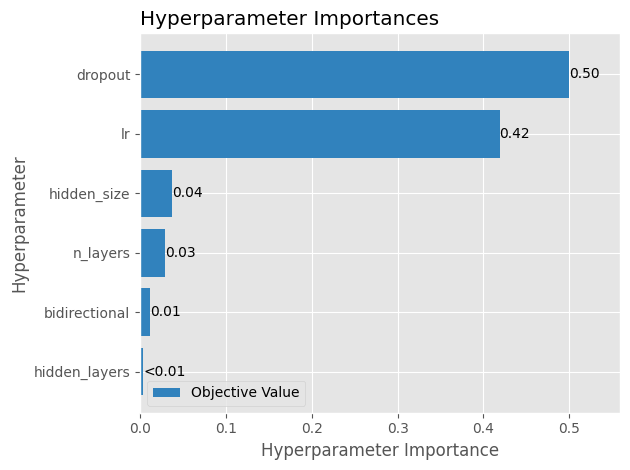

In [12]:
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

/tmp/ipykernel_396643/2297176039.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2024-05-26 23:51:16,063] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


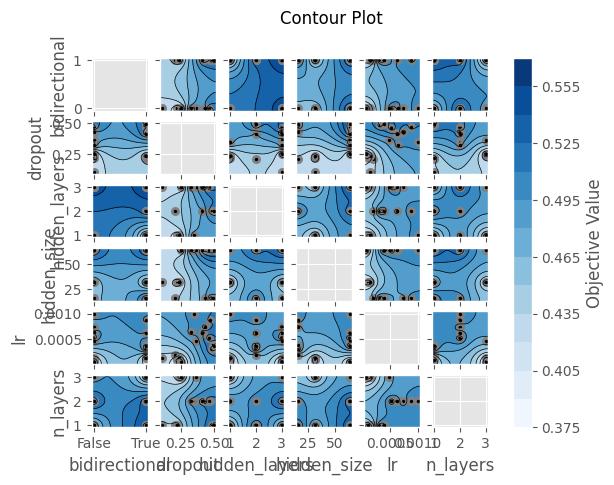

In [13]:
fig = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

## Finałowy model

In [22]:
dropout = 0.4
hidden_size = 64
n_layers = 2
hidden_layers = 3
lr = 0.0006
bidirectional = True

model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
model = model.to(device)
class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
class_weights = 1 / class_counts.float()
class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_hist, train_acc, val_acc = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=100, device=device)
final_accuracy = get_accuracy_features(model, test_loader, device)
print(f"Final accuracy: {final_accuracy}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, loss: 0.825


 10%|█         | 10/100 [05:33<50:14, 33.50s/it]

Epoch: 10, loss: 0.11


 20%|██        | 20/100 [11:09<44:54, 33.68s/it]

Epoch: 20, loss: 0.00544


 30%|███       | 30/100 [16:45<39:13, 33.62s/it]

Epoch: 30, loss: 0.00447


 40%|████      | 40/100 [22:27<34:23, 34.39s/it]

Epoch: 40, loss: 0.000108


 50%|█████     | 50/100 [28:13<28:48, 34.57s/it]

Epoch: 50, loss: 0.00956


 60%|██████    | 60/100 [33:58<23:01, 34.53s/it]

Epoch: 60, loss: 0.00362


 70%|███████   | 70/100 [39:45<17:19, 34.63s/it]

Epoch: 70, loss: 0.000211


 80%|████████  | 80/100 [45:31<11:31, 34.59s/it]

Epoch: 80, loss: 0.716


 90%|█████████ | 90/100 [51:18<05:47, 34.73s/it]

Epoch: 90, loss: 0.000213


100%|██████████| 100/100 [57:05<00:00, 34.25s/it]


Final accuracy: 0.6207482993197279


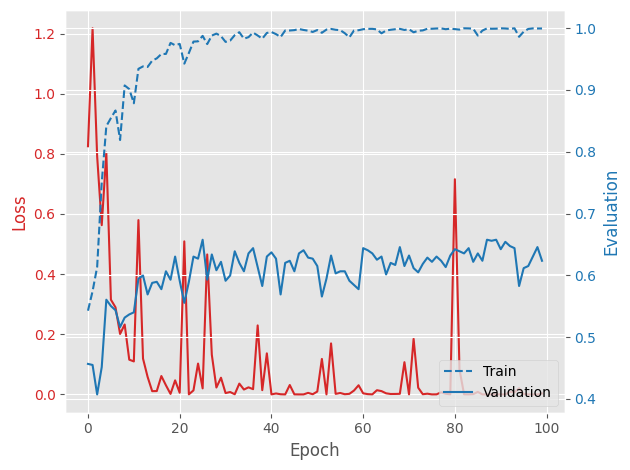

In [23]:
plot_training(loss_hist, train_acc, val_acc)

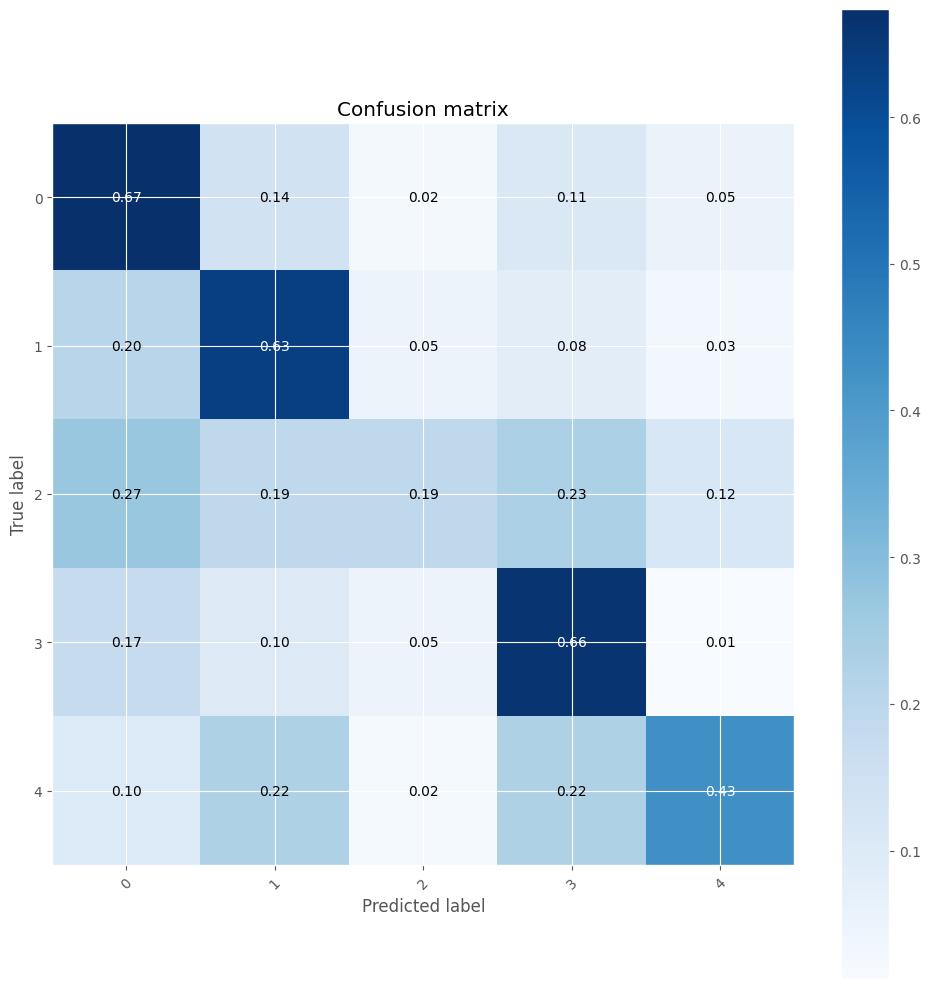

In [24]:
classes = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
cm = get_confusion_matrix_features(model, val_loader, 5, device)
plot_confusion_matrix(cm, classes)

In [17]:
dropout = 0.25
hidden_size = 16
n_layers = 3
hidden_layers = 3
lr = 0.0005
bidirectional = False

model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
model = model.to(device)
class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
class_weights = 1 / class_counts.float()
class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_hist, train_acc, val_acc = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=1, device=device)
final_accuracy = get_accuracy_features(model, test_loader, device)
print(f"Final accuracy: {final_accuracy}")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, loss: 1.37


100%|██████████| 1/1 [00:21<00:00, 21.13s/it]


Final accuracy: 0.33843537414965985


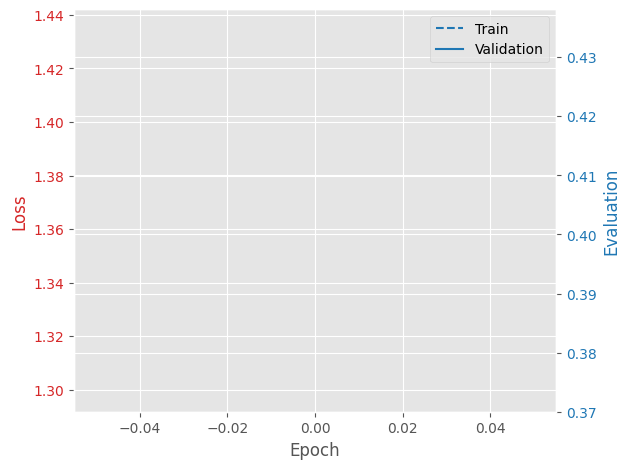

In [18]:
plot_training(loss_hist, train_acc, val_acc)

In [19]:
torch.save(model.state_dict(), 'lstm_features.pth')

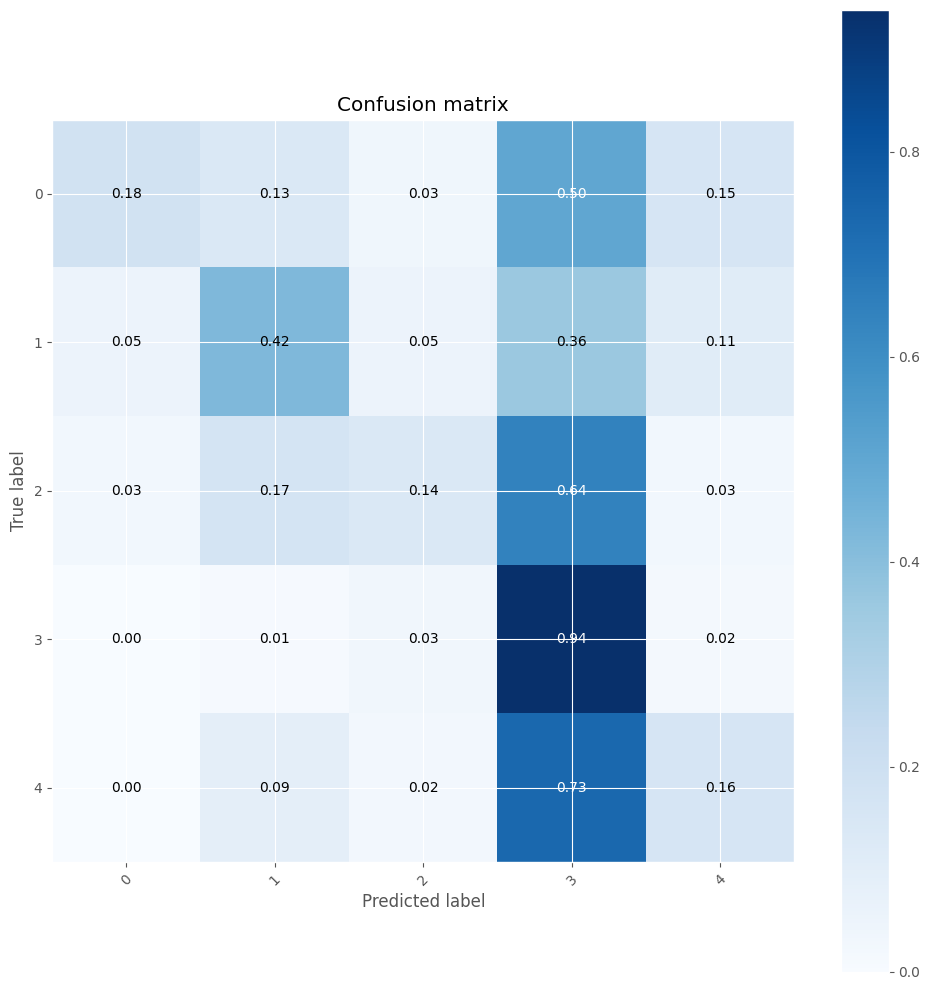

In [20]:
classes = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
cm = get_confusion_matrix_features(model, test_loader, 5, device)
plot_confusion_matrix(cm, classes)

In [21]:
final_accuracy = get_accuracy_features(model, test_loader, device)
print(f"Test accuracy: {final_accuracy}")

Test accuracy: 0.33843537414965985
